In [1]:
import json
import pandas as pd

# reminder that if you are installing libraries in a Google Colab instance you will be prompted to restart your kernal

try:
    import geemap, ee
    import seaborn as sns
    import matplotlib.pyplot as plt
except ModuleNotFoundError:
    if 'google.colab' in str(get_ipython()):
        print("package not found, installing w/ pip in Google Colab...")
        !pip install geemap seaborn matplotlib
    else:
        print("package not found, installing w/ conda...")
        !conda install mamba -c conda-forge -y
        !mamba install geemap -c conda-forge -y
        !conda install seaborn matplotlib -y
    import geemap, ee
    import seaborn as sns
import tqdm
try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()

In [10]:
# import new_merge_with_macro.csv
df_new = pd.read_csv(r'C:\Users\WeilunShi\OneDrive - CGIAR\Desktop\Food Crisis and Insecurity\new_merge_with_macro.csv')

In [12]:
# extract distinct lat and lon from df_new
location = df_new[['lat', 'lon']].drop_duplicates()

In [14]:
location.reset_index(drop=True, inplace=True)

In [45]:
# create a empty dataframe to store the result
result = pd.DataFrame(columns=['date', 'mean','stdDev','lat','lon'])
# loop over location
for i in tqdm.tqdm(range(len(location))):
    # identify a 500 meter buffer around our Point Of Interest (POI)
    poi = ee.Geometry.Point(location['lat'][i], location['lon'][i]).buffer(500)

    viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate('2017-01-01','2022-12-31')
    def poi_mean(img):
        mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=poi, scale=30).get('avg_rad')
        return img.set('date', img.date().format()).set('mean',mean)
    def poi_sd(img):
        stdDev = img.reduceRegion(reducer=ee.Reducer.stdDev(), geometry=poi, scale=30).get('avg_rad')
        return img.set('date', img.date().format()).set('stdDev',stdDev)
    poi_reduced_imgs_mean = viirs.map(poi_mean)
    poi_reduced_imgs_sd = viirs.map(poi_sd)
    nested_list_mean = poi_reduced_imgs_mean.reduceColumns(ee.Reducer.toList(2), ['date','mean']).values().get(0)
    nested_list_sd = poi_reduced_imgs_sd.reduceColumns(ee.Reducer.toList(2), ['date','stdDev']).values().get(0)
    # dont forget we need to call the callback method "getInfo" to retrieve the data
    df_1 = pd.DataFrame(nested_list_mean.getInfo(), columns=['date','mean'])
    df_2 = pd.DataFrame(nested_list_sd.getInfo(), columns=['date','stdDev'])
    # merge on date
    df = pd.merge(df_1, df_2, on='date')
    df['lat'] = location['lat'][i]
    df['lon'] = location['lon'][i]
    df['date'] = pd.to_datetime(df['date'])
    # append the result to df_night_light
    result = pd.concat([result, df], axis=0)

  0%|          | 0/1878 [00:00<?, ?it/s]

100%|██████████| 1878/1878 [51:42<00:00,  1.65s/it] 


In [47]:
# rename mean as  night_light_mean and stdDev as night_light_stdDev
result.rename(columns={'mean':'night_light_mean','stdDev':'night_light_stdDev'}, inplace=True)

In [51]:
# see if date, lat, lon form a unique key
result[['date','lat','lon']].duplicated().sum()

0

In [52]:
# see if date, lat, lon form a unique key
df_new[['date','lat','lon']].duplicated().sum()

0

In [54]:
# convert date to datetime
result['date'] = pd.to_datetime(result['date'])
df_new['date'] = pd.to_datetime(df_new['date'])

In [55]:
# merge df_new and result, add indicator
df_merged = pd.merge(df_new, result, on=['date','lat','lon'], how='left', indicator=True)

In [56]:
df_merged['_merge'].value_counts()

_merge
both          35379
left_only      3397
right_only        0
Name: count, dtype: int64

In [57]:
# drop _merge
df_merged.drop('_merge', axis=1, inplace=True)

In [59]:
# rename night_light_stdDev as night_light_sd
df_merged.rename(columns={'night_light_stdDev':'night_light_sd'}, inplace=True)

In [60]:
# export df_merged as csv
df_merged.to_csv(r'C:\Users\WeilunShi\OneDrive - CGIAR\Desktop\Food Crisis and Insecurity\new_merge_complete.csv', index=False)

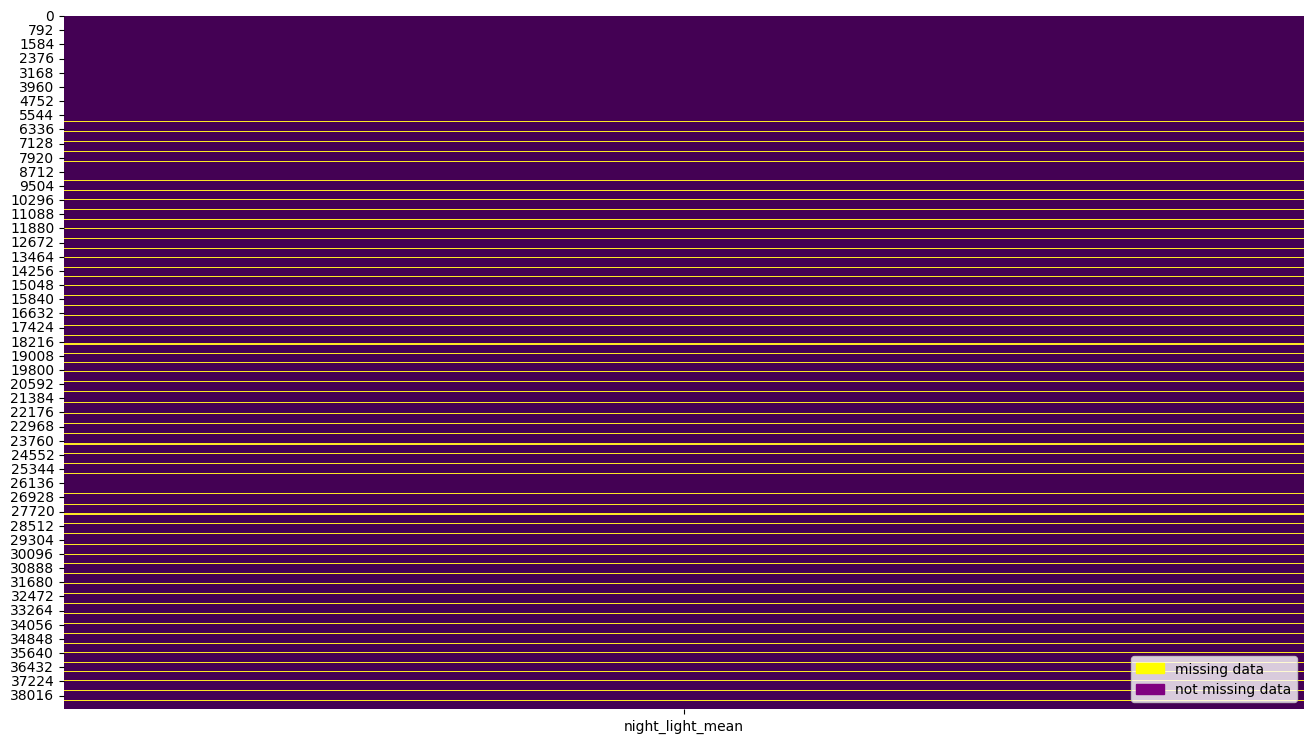

In [61]:
col = 'night_light_mean'
new_df = df_merged

df = new_df[[col]]  # convert Series to DataFrame with a single column
import matplotlib.patches as mpatches

plt.figure(figsize=(16,9))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')

# create legend
missing_data_patch = mpatches.Patch(color='yellow', label='missing data')
not_missing_data_patch = mpatches.Patch(color='purple', label='not missing data')
plt.legend(handles=[missing_data_patch, not_missing_data_patch], loc='lower right')

plt.savefig('missing_data_' + col + '.png')

plt.show()

missing_percentage = df.isnull().sum() * 100 / len(df)

# Step 1: Create a DataFrame to hold the missing data report
missing_data = pd.DataFrame()

# Step 2: Calculate the total number of missing values for each variable
missing_data['Total'] = df.isnull().sum()

# Step 3: Calculate the percentage of missing values for each variable
missing_data['Percent'] = df.isnull().mean() * 100

missing_data.to_csv('missing_data_report_' + col + '.csv')

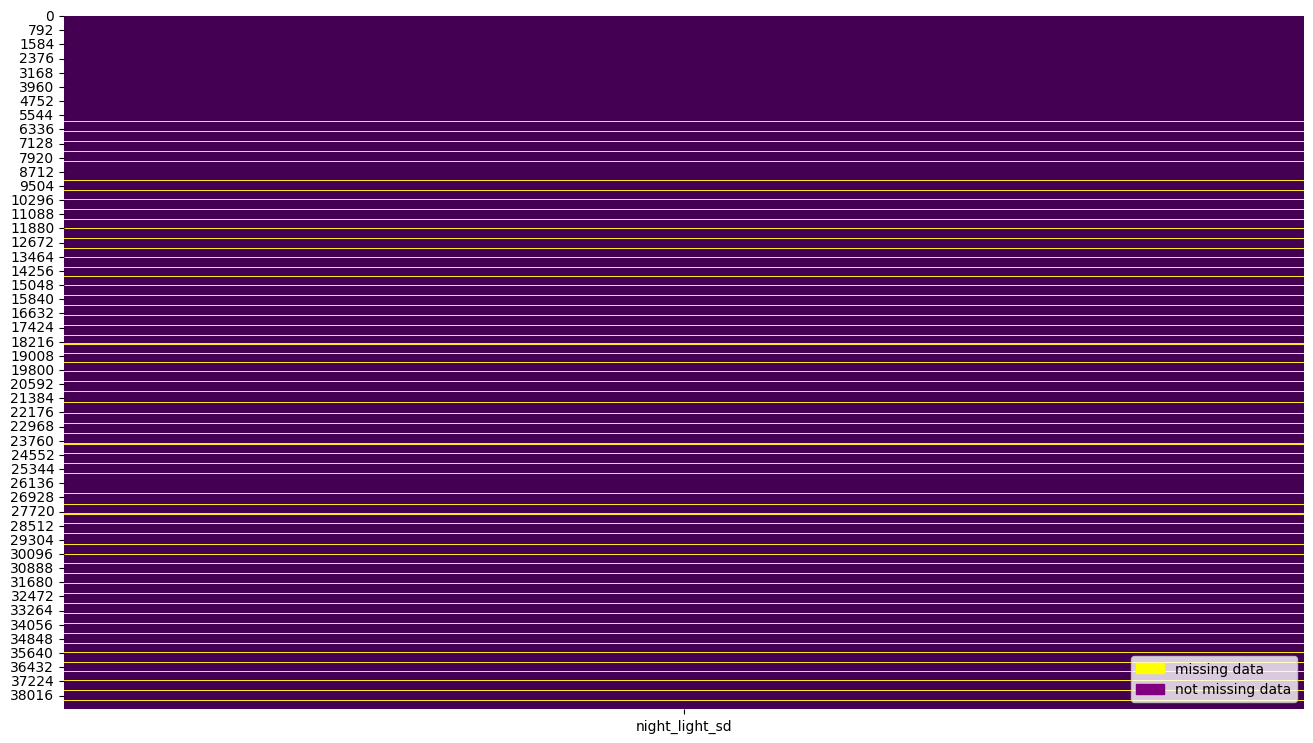

In [62]:
col = 'night_light_sd'
new_df = df_merged

df = new_df[[col]]  # convert Series to DataFrame with a single column
import matplotlib.patches as mpatches

plt.figure(figsize=(16,9))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')

# create legend
missing_data_patch = mpatches.Patch(color='yellow', label='missing data')
not_missing_data_patch = mpatches.Patch(color='purple', label='not missing data')
plt.legend(handles=[missing_data_patch, not_missing_data_patch], loc='lower right')

plt.savefig('missing_data_' + col + '.png')

plt.show()

missing_percentage = df.isnull().sum() * 100 / len(df)

# Step 1: Create a DataFrame to hold the missing data report
missing_data = pd.DataFrame()

# Step 2: Calculate the total number of missing values for each variable
missing_data['Total'] = df.isnull().sum()

# Step 3: Calculate the percentage of missing values for each variable
missing_data['Percent'] = df.isnull().mean() * 100

missing_data.to_csv('missing_data_report_' + col + '.csv')

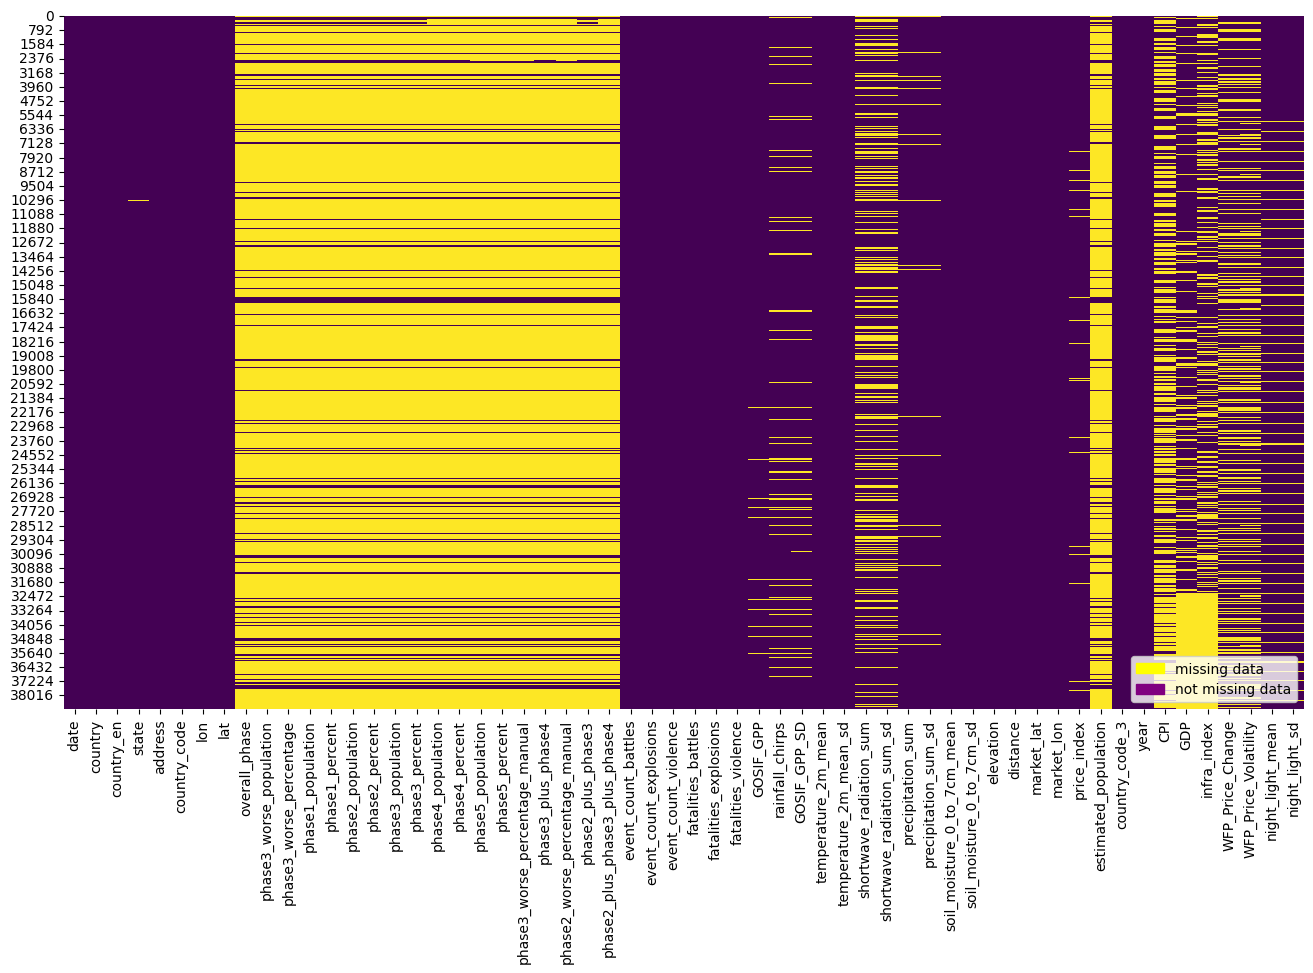

In [63]:
# select the column
df = new_df

import matplotlib.patches as mpatches

plt.figure(figsize=(16,9))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')

# create legend
missing_data_patch = mpatches.Patch(color='yellow', label='missing data')
not_missing_data_patch = mpatches.Patch(color='purple', label='not missing data')
plt.legend(handles=[missing_data_patch, not_missing_data_patch], loc='lower right')

plt.savefig('missing_data.png')

plt.show()